In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to load and standardize model ranking data
def load_model_rankings():
    topics = []
    for topic in range(1, 4):
        for prompt in range(1, 4):
            file = f"topic {topic} prompt {prompt}.csv"
            df = pd.read_csv(file)
            df["Topic"] = topic
            df["Prompt Length"] = prompt  # 1=concise, 2=medium, 3=long
            topics.append(df)
            df.columns = ["Model", "Rank", "Count", "Topic", "Prompt Length"]
            # rename the Prompt Length to 1=concise, 2=medium, 3=long
            df["Prompt Length"] = df["Prompt Length"].map(
                {1: "Concise", 2: "Medium", 3: "Long"}
            )

    combined_df = pd.concat(topics, ignore_index=True)
    return combined_df

In [3]:
# Function to load prompt length preference data
def load_prompt_rankings():
    rankings = []
    for topic in range(1, 4):
        file = f"topic {topic} prompts ranking.csv"
        df = pd.read_csv(file)
        df["Topic"] = topic
        rankings.append(df)
        df.columns = ["Prompt Length", "Percentage", "Count", "Topic"]

    combined_df = pd.concat(rankings, ignore_index=True)
    # Clean column names and data
    combined_df["Percentage"] = combined_df["Percentage"].str.rstrip("%").astype(float)

    # Convert "Prompt 1" to "Concise", "Prompt 2" to "Medium", and "Prompt 3" to "Long" in "Prompt Length" column
    combined_df["Prompt Length"] = combined_df["Prompt Length"].map(
        {
            "Prompt 1": "Concise",
            "Prompt 2": "Medium",
            "Prompt 3": "Long",
        }
    )
    return combined_df


# Load both datasets
model_rankings = load_model_rankings()
prompt_rankings = load_prompt_rankings()

In [4]:
prompt_rankings

,Prompt Length,Percentage,Count,Topic
0,Concise,24.0,10,1
1,Medium,54.0,22,1
2,Long,22.0,9,1
3,Concise,53.0,21,2
4,Medium,25.0,10,2
5,Long,23.0,9,2
6,Concise,28.0,11,3
7,Medium,28.0,11,3
8,Long,45.0,18,3


In [5]:
model_rankings

,Model,Rank,Count,Topic,Prompt Length
0,DreamBooth,1,26,1,Concise
1,DreamBooth,2,14,1,Concise
2,DreamBooth,3,0,1,Concise
3,Textual Inversion,1,12,1,Concise
4,Textual Inversion,2,16,1,Concise
...,...,...,...,...,...
76,Textual Inversion,2,10,3,Long
77,Textual Inversion,3,21,3,Long
78,SD Base,1,8,3,Long
79,SD Base,2,16,3,Long


In [6]:
# Group by Model and Rank, sum the Count column, and unstack
ranked_sums = model_rankings.groupby(["Model", "Rank"])["Count"].sum().unstack()
ranked_sums.columns = [f"Rank {i}" for i in ranked_sums.columns]

# Concise prompts (length=1)
ranked_sums_concise = (
    model_rankings[model_rankings["Prompt Length"] == "Concise"]
    .groupby(["Model", "Rank"])["Count"]
    .sum()
    .unstack()
)
ranked_sums_concise.columns = [f"Rank {i}" for i in ranked_sums_concise.columns]

# Medium prompts (length=2)
ranked_sums_medium = (
    model_rankings[model_rankings["Prompt Length"] == "Medium"]
    .groupby(["Model", "Rank"])["Count"]
    .sum()
    .unstack()
)
ranked_sums_medium.columns = [f"Rank {i}" for i in ranked_sums_medium.columns]

# Long prompts (length=3)
ranked_sums_long = (
    model_rankings[model_rankings["Prompt Length"] == "Long"]
    .groupby(["Model", "Rank"])["Count"]
    .sum()
    .unstack()
)
ranked_sums_long.columns = [f"Rank {i}" for i in ranked_sums_long.columns]

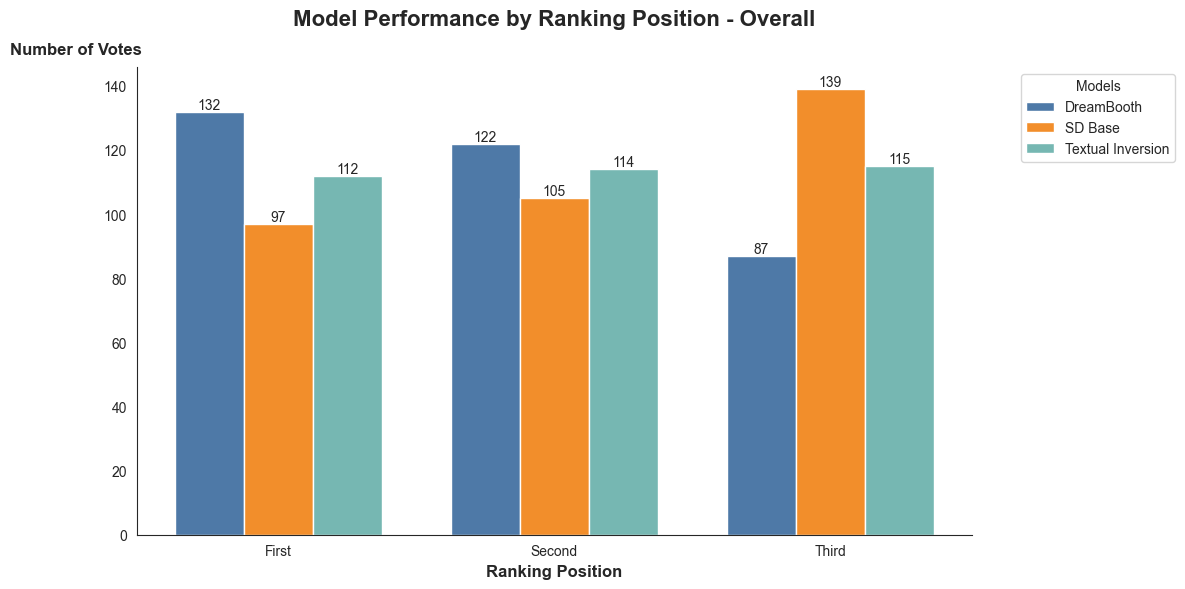

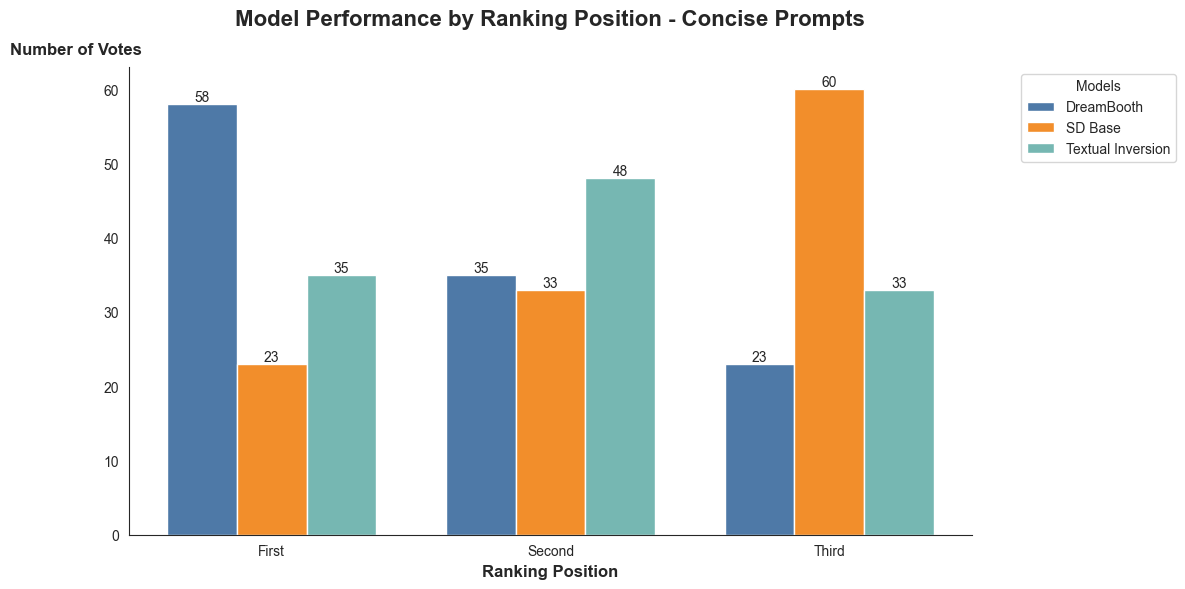

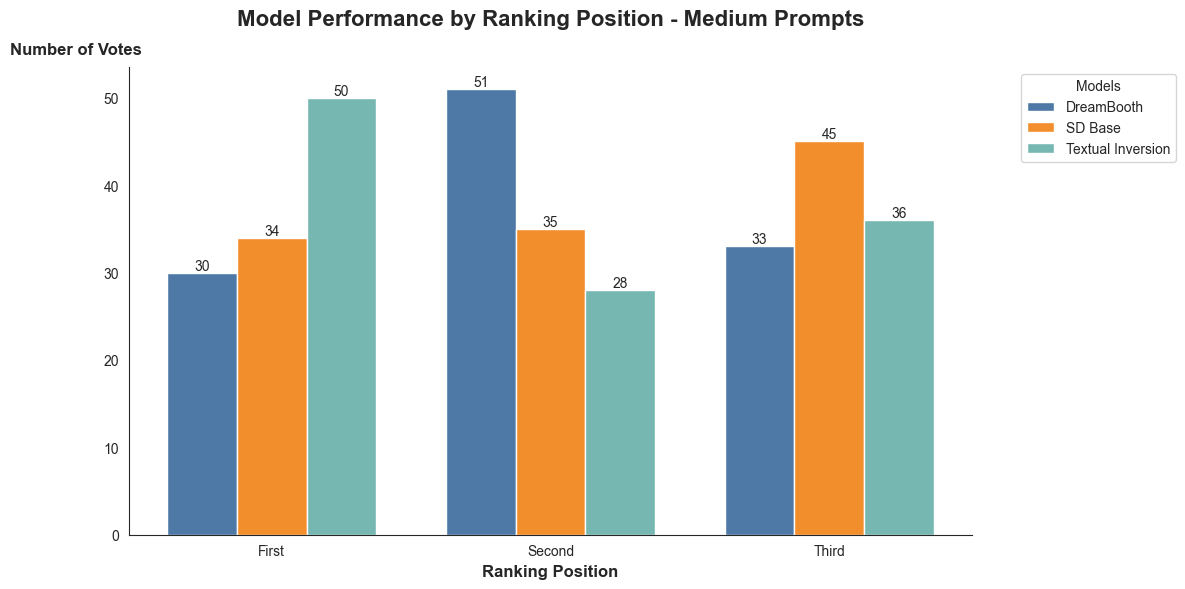

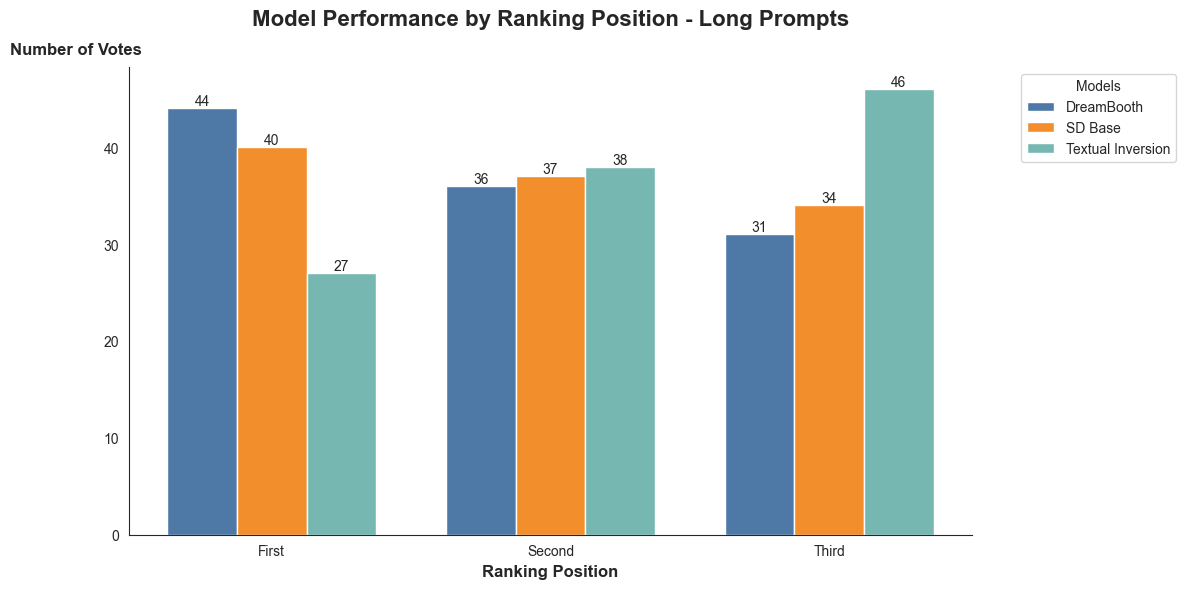

In [7]:
def plot_model_rankings_rank_cluster(data, title):
    """
    Create a clustered bar plot for model rankings

    Parameters:
    data: DataFrame with model rankings
    title: String for plot title
    """
    # Set style and create figure
    sns.set_style("white")
    plt.figure(figsize=(12, 6))

    # Prepare data
    ranks = ["First", "Second", "Third"]
    models = data.index
    x = np.arange(len(ranks))
    width = 0.25

    # Define professional color palette
    colors = ["#4e79a7", "#f28e2b", "#76b7b2"]

    # Create bars for each model
    bar1 = plt.bar(
        x - width, data.loc["DreamBooth"], width, label="DreamBooth", color=colors[0]
    )
    bar2 = plt.bar(x, data.loc["SD Base"], width, label="SD Base", color=colors[1])
    bar3 = plt.bar(
        x + width,
        data.loc["Textual Inversion"],
        width,
        label="Textual Inversion",
        color=colors[2],
    )

    # Customize plot
    plt.xlabel("Ranking Position", fontsize=12, fontweight="bold")
    plt.ylabel(
        "Number of Votes",
        fontsize=12,
        fontweight="bold",
        rotation=0,
        labelpad=20,
        y=1.02,
    )
    plt.title(title, fontsize=16, fontweight="bold", pad=30)
    plt.xticks(x, ranks)
    plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Add value labels
    for bars in [bar1, bar2, bar3]:
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{int(height)}",
                ha="center",
                va="bottom",
            )

    # Remove spines and show plot
    sns.despine()
    plt.tight_layout()
    plt.show()


# Generate plots for all ranking types
plot_model_rankings_rank_cluster(
    ranked_sums, "Model Performance by Ranking Position - Overall"
)
plot_model_rankings_rank_cluster(
    ranked_sums_concise, "Model Performance by Ranking Position - Concise Prompts"
)
plot_model_rankings_rank_cluster(
    ranked_sums_medium, "Model Performance by Ranking Position - Medium Prompts"
)
plot_model_rankings_rank_cluster(
    ranked_sums_long, "Model Performance by Ranking Position - Long Prompts"
)

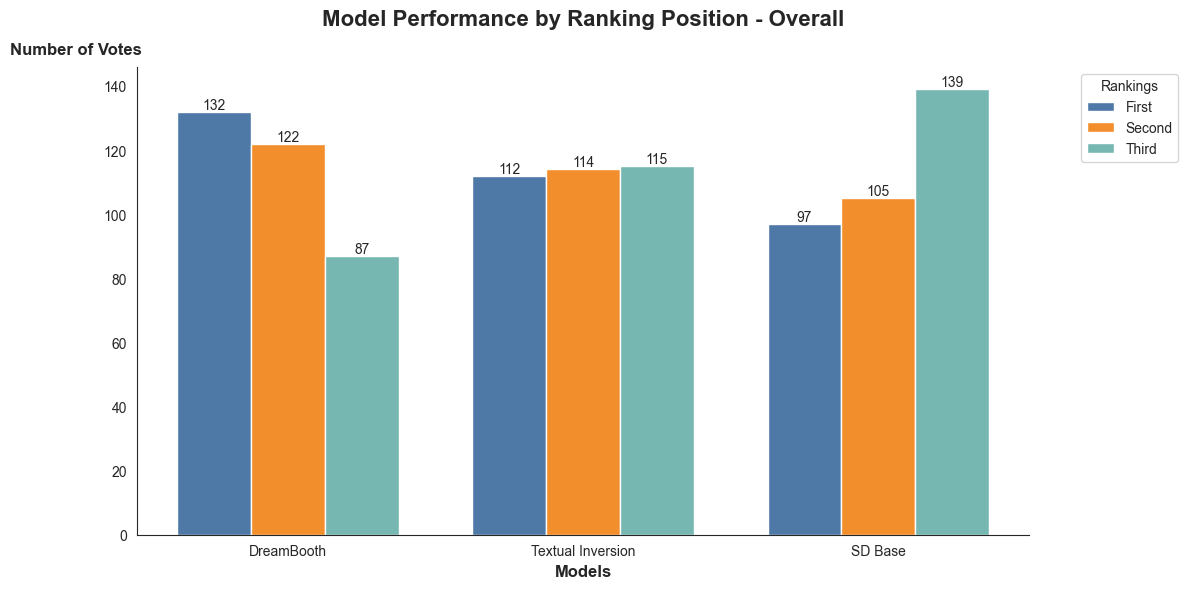

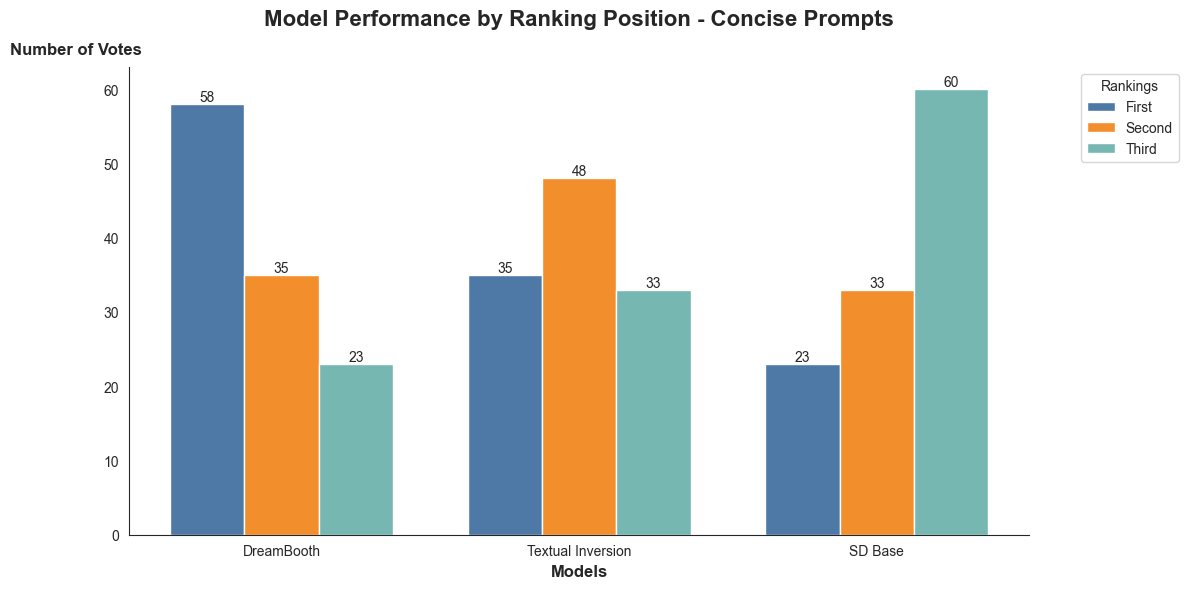

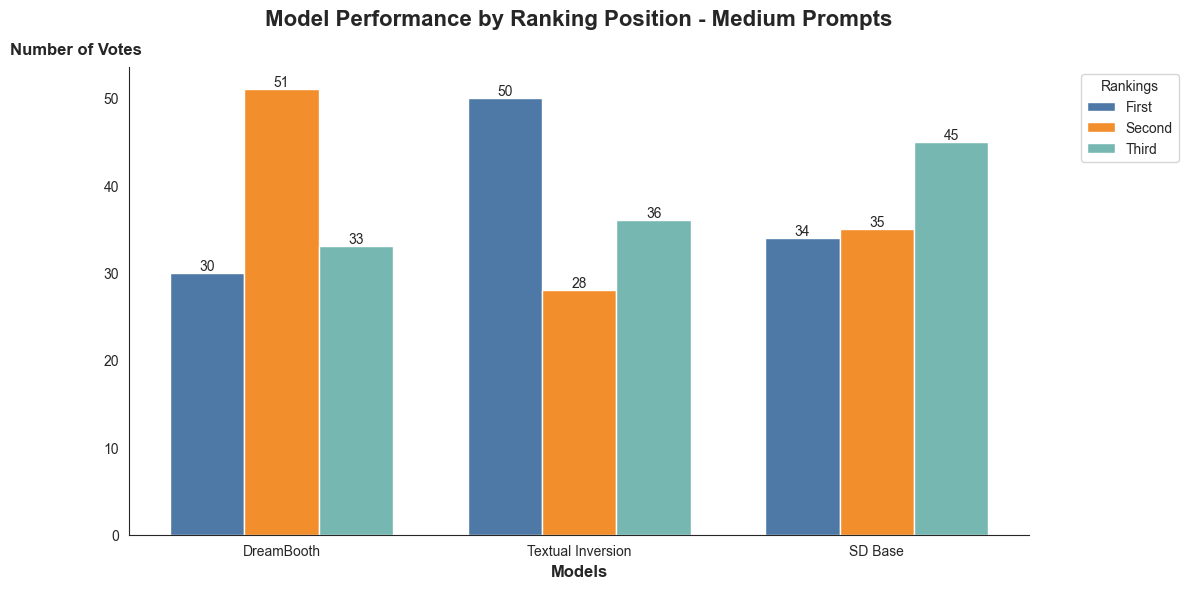

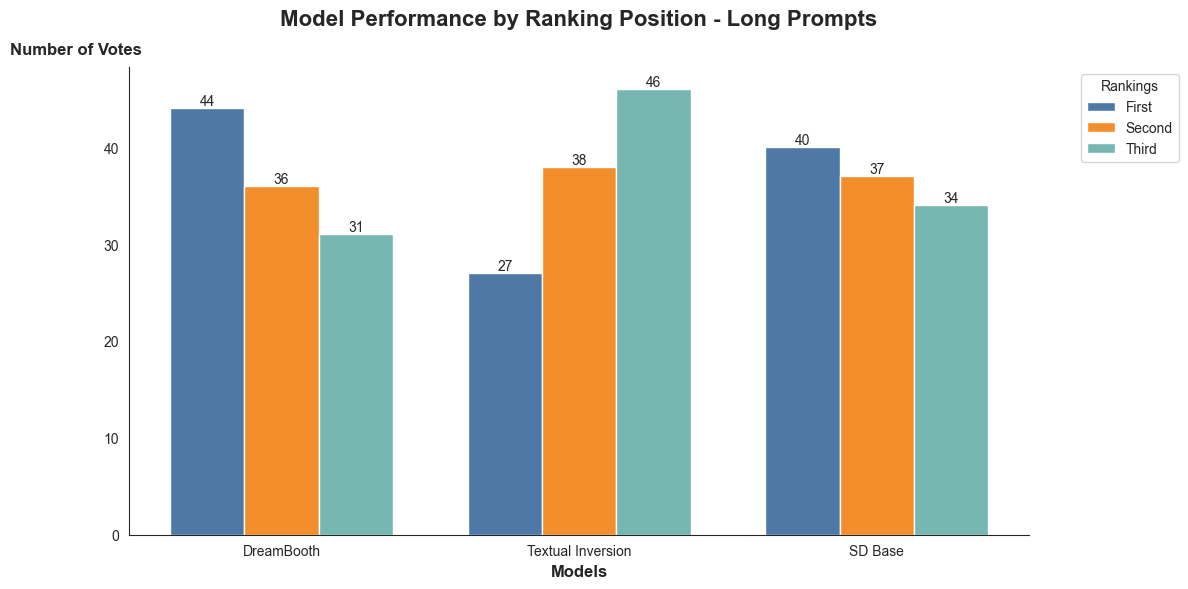

In [8]:
def plot_model_rankings_model_cluster(data, title):
    """
    Create a clustered bar plot for model rankings, grouped by model

    Parameters:
    data: DataFrame with model rankings
    title: String for plot title
    """
    # Set style and create figure
    sns.set_style("white")
    plt.figure(figsize=(12, 6))

    # Prepare data
    desired_order = ["DreamBooth", "Textual Inversion", "SD Base"]
    data = data.reindex(desired_order)
    models = data.index
    x = np.arange(len(models))
    width = 0.25

    # Define professional color palette
    colors = ["#4e79a7", "#f28e2b", "#76b7b2"]

    # Create bars for each ranking position
    bar1 = plt.bar(
        x - width,
        [data.loc[model]["Rank 1"] for model in models],
        width,
        label="First",
        color=colors[0],
    )
    bar2 = plt.bar(
        x,
        [data.loc[model]["Rank 2"] for model in models],
        width,
        label="Second",
        color=colors[1],
    )
    bar3 = plt.bar(
        x + width,
        [data.loc[model]["Rank 3"] for model in models],
        width,
        label="Third",
        color=colors[2],
    )

    # Customize plot
    plt.xlabel("Models", fontsize=12, fontweight="bold")
    plt.ylabel(
        "Number of Votes",
        fontsize=12,
        fontweight="bold",
        rotation=0,
        labelpad=20,
        y=1.02,
    )
    plt.title(title, fontsize=16, fontweight="bold", pad=30)
    plt.xticks(x, models)
    plt.legend(title="Rankings", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Add value labels
    for bars in [bar1, bar2, bar3]:
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{int(height)}",
                ha="center",
                va="bottom",
            )

    # Remove spines and show plot
    sns.despine()
    plt.tight_layout()
    plt.show()


# Generate plots for all ranking types
plot_model_rankings_model_cluster(
    ranked_sums.copy(), "Model Performance by Ranking Position - Overall"
)
plot_model_rankings_model_cluster(
    ranked_sums_concise.copy(),
    "Model Performance by Ranking Position - Concise Prompts",
)
plot_model_rankings_model_cluster(
    ranked_sums_medium.copy(), "Model Performance by Ranking Position - Medium Prompts"
)
plot_model_rankings_model_cluster(
    ranked_sums_long.copy(), "Model Performance by Ranking Position - Long Prompts"
)

In [9]:
prompt_rankings

# group by Prompt Length , sum the Count column
prompt_sums = prompt_rankings.groupby(["Prompt Length"])["Count"].sum().reset_index()

prompt_sums

,Prompt Length,Count
0,Concise,42
1,Long,36
2,Medium,43


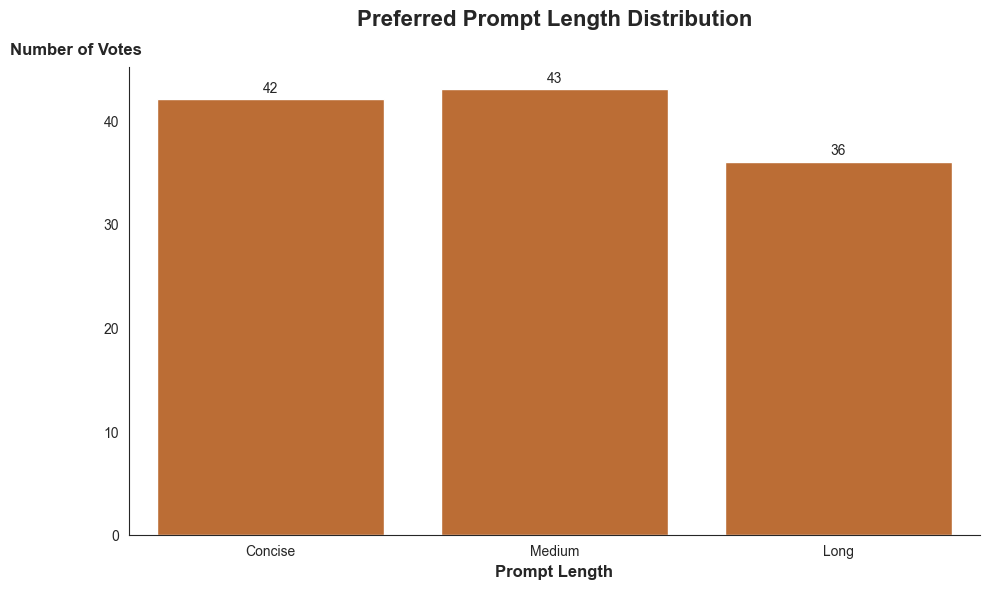

In [10]:
# Set style
sns.set_style("white")
plt.figure(figsize=(10, 6))

# Create bar plot with consistent color scheme
bar_plot = sns.barplot(
    data=prompt_sums,
    x="Prompt Length",
    y="Count",
    color="#D2691E",
    order=["Concise", "Medium", "Long"],
)

# Customize plot
plt.title(
    "Preferred Prompt Length Distribution", fontsize=16, fontweight="bold", pad=30
)
plt.xlabel("Prompt Length", fontsize=12, fontweight="bold")
plt.ylabel(
    "Number of Votes", fontsize=12, fontweight="bold", rotation=0, labelpad=20, y=1.02
)
# Remove spines
sns.despine()
plt.savefig("Preferred Prompt Length Distribution.png", dpi=300, bbox_inches="tight")

# Add value labels
for i in bar_plot.containers:
    bar_plot.bar_label(i, padding=3)


plt.tight_layout()
plt.show()

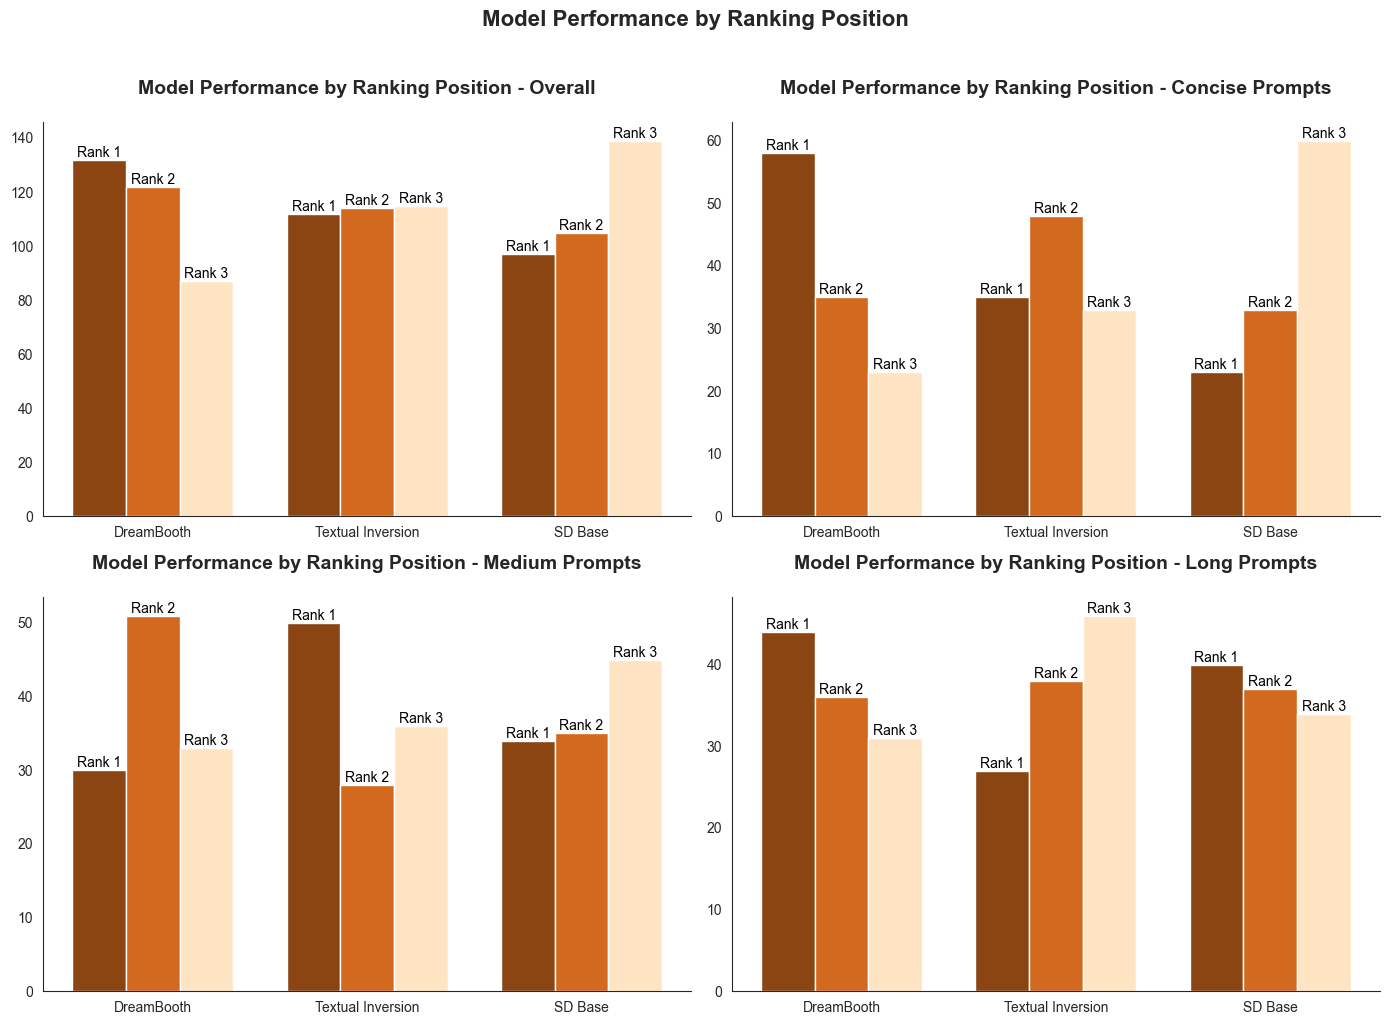

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_model_rankings_model_cluster(data, title, ax):
    """
    Create a clustered bar plot for model rankings, grouped by model

    Parameters:
    data: DataFrame with model rankings
    title: String for plot title
    ax: Axes object to plot on
    """
    # Prepare data
    desired_order = ["DreamBooth", "Textual Inversion", "SD Base"]
    data = data.reindex(desired_order)
    models = data.index
    x = np.arange(len(models))
    width = 0.25

    # Define professional color palette
    colors = ["#8B4513", "#D2691E", "#FFE4C4"]

    # Create bars for each ranking position
    bar1 = ax.bar(
        x - width,
        [data.loc[model]["Rank 1"] for model in models],
        width,
        color=colors[0],
    )
    bar2 = ax.bar(
        x,
        [data.loc[model]["Rank 2"] for model in models],
        width,
        color=colors[1],
    )
    bar3 = ax.bar(
        x + width,
        [data.loc[model]["Rank 3"] for model in models],
        width,
        color=colors[2],
    )

    # Customize plot
    ax.set_title(title, fontsize=14, fontweight="bold", pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(models)

    # Add rank labels instead of count labels
    for bars, rank in zip([bar1, bar2, bar3], [1, 2, 3]):
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                bar.get_height(),
                f"Rank {rank}",
                ha="center",
                va="bottom",
                fontsize=10,
                color="black",
            )

    # Remove spines
    sns.despine(ax=ax)


def plot_all_model_rankings(data_list, titles, main_title):
    """
    Generate a 2x2 grid of plots for model rankings

    Parameters:
    data_list: List of DataFrames with model rankings
    titles: List of titles for each subplot
    main_title: String for the main title of the grid
    """
    sns.set_style("white")
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(main_title, fontsize=16, fontweight="bold", y=1.02)

    for data, title, ax in zip(data_list, titles, axs.flatten()):
        plot_model_rankings_model_cluster(data, title, ax)

    plt.tight_layout()
    plt.savefig("model_rankings_grid.png", dpi=300, bbox_inches="tight")
    plt.show()


# Generate plots for all ranking types in a 2x2 grid
data_list = [
    ranked_sums.copy(),
    ranked_sums_concise.copy(),
    ranked_sums_medium.copy(),
    ranked_sums_long.copy(),
]
titles = [
    "Model Performance by Ranking Position - Overall",
    "Model Performance by Ranking Position - Concise Prompts",
    "Model Performance by Ranking Position - Medium Prompts",
    "Model Performance by Ranking Position - Long Prompts",
]
main_title = "Model Performance by Ranking Position"

plot_all_model_rankings(data_list, titles, main_title)

C:\Users\osama\AppData\Local\Temp\ipykernel_35668\2649947237.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Weighted Score", y=data.index, data=data, palette=colors)


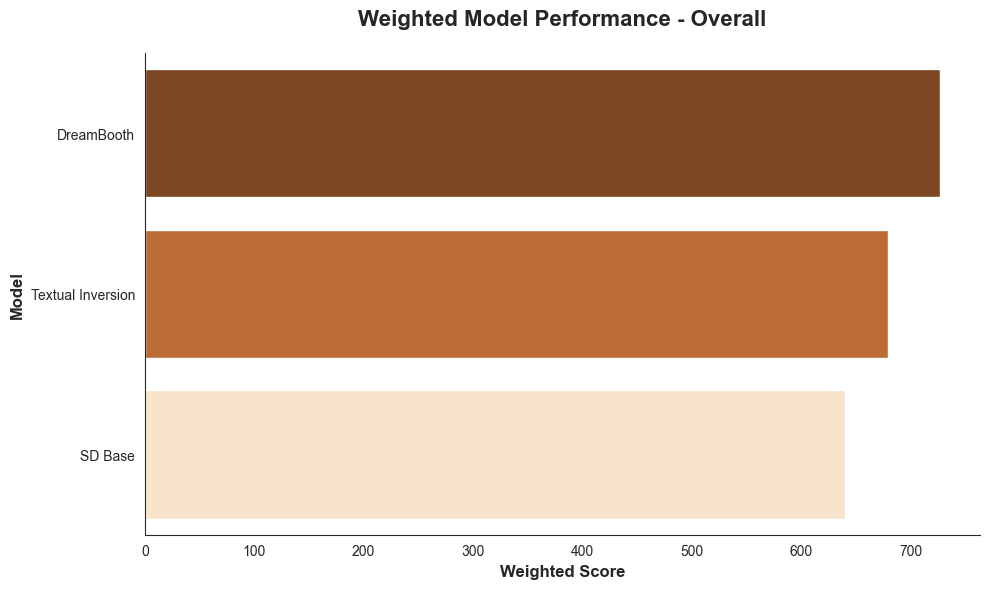

In [12]:
def plot_weighted_model_performance(data, title):
    """
    Create a horizontal bar plot for weighted model performance

    Parameters:
    data: DataFrame with model rankings
    title: String for plot title
    """
    # Calculate weighted scores
    weights = {"Rank 1": 3, "Rank 2": 2, "Rank 3": 1}
    data["Weighted Score"] = (
        data["Rank 1"] * weights["Rank 1"]
        + data["Rank 2"] * weights["Rank 2"]
        + data["Rank 3"] * weights["Rank 3"]
    )

    # Sort data by weighted score
    data = data.sort_values(by="Weighted Score", ascending=False)

    # Define professional color palette
    colors = ["#8B4513", "#D2691E", "#FFE4C4"]

    # Plot horizontal bar chart
    sns.set_style("white")
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Weighted Score", y=data.index, data=data, palette=colors)

    # Customize plot
    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.xlabel("Weighted Score", fontsize=12, fontweight="bold")
    plt.ylabel("Model", fontsize=12, fontweight="bold")

    sns.despine()
    plt.tight_layout()
    plt.savefig("weighted_model_performance.png", dpi=300, bbox_inches="tight")
    plt.show()


# Generate weighted performance plot
plot_weighted_model_performance(
    ranked_sums.copy(), "Weighted Model Performance - Overall"
)